In [1]:
# Pagrindinės bibliotekos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Vizualizacijai, atkreipkite dėmesį, kad naudojame "matplotlib" pagrindu
import warnings
import requests
from datetime import datetime
from bs4 import BeautifulSoup
import time
import sqlite3

# Duomenų modeliavimas ir analizė
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Darbas su interneto naršyklėmis per Selenium
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

# Įspėjimų ignoravimas
warnings.filterwarnings('ignore')

# Specializuoti moduliai
from numpy.polynomial import Polynomial

In [2]:
# Uzduotis nr. 1  - Stacionaro ir ambulatoriniai ligoniai, gydyti nuo traumų ir apsinuodijimų. 
# - Įvertinkite patiriamų traumų, apsinuodijimų dažnius/pasiskirstymą, sunkumą pagal amžių/amžiaus # grupes, lytį, paros, metų, darbo dienų/švenčių/išeiginių. 

# ligonine = pd.read_csv('C:/Users/Pauliussl/Paskaita85/Ligonine.csv'
kodai = pd.read_excel('C:/Users/Pauliussl/Paskaita85/Kodai.xlsx')
pacientas = pd.read_csv('C:/Users/Pauliussl/Paskaita85/Pacientas.csv')

sujungti_duomenys = pd.merge(pacientas, kodai, left_on='tlk_trauma', right_on='TLK-10-AM Kodas', how='left')
final_lentele = sujungti_duomenys[['gyd_lap_pradzia', 'lytis', 'vda_gim_metai', 'tlk_trauma', 'TLK-10-AM Kodo pavadinimas']]
final_lentele.rename(columns={'TLK-10-AM Kodo pavadinimas': 'ligos_pavadinimas'}, inplace=True)

In [3]:
final_lentele['vda_gim_metai'] = pd.to_datetime(final_lentele['vda_gim_metai'], errors='coerce')
final_lentele['gyd_lap_pradzia'] = pd.to_datetime(final_lentele['gyd_lap_pradzia'], errors='coerce')
final_lentele['amzius'] = final_lentele.apply(lambda x: (x['gyd_lap_pradzia'].date() - x['vda_gim_metai'].date()).days // 365 if pd.notna(x['vda_gim_metai']) and pd.notna(x['gyd_lap_pradzia']) else None, axis=1)
final_lentele['amziaus_grupe'] = pd.cut(final_lentele['amzius'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, float('inf')], labels=['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '>80'], right=False)
final_lentele

,gyd_lap_pradzia,lytis,vda_gim_metai,tlk_trauma,ligos_pavadinimas,amzius,amziaus_grupe
0,2013-01-01,Vyras,1998-01-01,S42.43,Žastikaulio viduriniojo krumplio lūžis,15.0,11-20
1,2022-08-01,Vyras,1973-01-01,S13.6,Kitų ir nepatikslintų kaklo dalių sąnarių raiš...,49.0,41-50
2,2018-02-01,Moteris,1960-01-01,S63.50,"Riešo patempimas, dalis nepatikslinta",58.0,51-60
3,2015-08-01,Vyras,1978-01-01,S68.2,Dviejų ar daugiau pirštų trauminė amputacija (...,37.0,31-40
4,2015-10-01,Vyras,2011-01-01,T18.9,"Svetimkūnis virškinimo trakte, dalis nepatiksl...",4.0,0-10
...,...,...,...,...,...,...,...
3731501,2021-04-01,Vyras,2011-01-01,S52.50,"Stipinkaulio apatinės dalies lūžis, nepatiksli...",10.0,11-20
3731502,2014-08-01,Vyras,1992-01-01,S02.2,Nosies kaulų lūžis,22.0,21-30
3731503,2015-08-01,Moteris,1992-01-01,S90.1,"Kojos piršto (-ų) sumušimas, kai nagas nepažei...",23.0,21-30
3731504,2023-09-01,Moteris,2022-01-01,T78.4,Nepatikslinta alergija,1.0,0-10


In [4]:
# Nusistatau sezona
final_lentele['sezonas'] = final_lentele['gyd_lap_pradzia'].dt.month.map({1: 'žiema', 2: 'žiema', 3: 'pavasaris', 4: 'pavasaris', 5: 'pavasaris', 6: 'vasara', 7: 'vasara', 8: 'vasara', 9: 'ruduo', 10: 'ruduo', 11: 'ruduo', 12: 'žiema'})
final_lentele['savaites_diena'] = final_lentele['gyd_lap_pradzia'].dt.weekday
final_lentele

,gyd_lap_pradzia,lytis,vda_gim_metai,tlk_trauma,ligos_pavadinimas,amzius,amziaus_grupe,sezonas,savaites_diena
0,2013-01-01,Vyras,1998-01-01,S42.43,Žastikaulio viduriniojo krumplio lūžis,15.0,11-20,žiema,1
1,2022-08-01,Vyras,1973-01-01,S13.6,Kitų ir nepatikslintų kaklo dalių sąnarių raiš...,49.0,41-50,vasara,0
2,2018-02-01,Moteris,1960-01-01,S63.50,"Riešo patempimas, dalis nepatikslinta",58.0,51-60,žiema,3
3,2015-08-01,Vyras,1978-01-01,S68.2,Dviejų ar daugiau pirštų trauminė amputacija (...,37.0,31-40,vasara,5
4,2015-10-01,Vyras,2011-01-01,T18.9,"Svetimkūnis virškinimo trakte, dalis nepatiksl...",4.0,0-10,ruduo,3
...,...,...,...,...,...,...,...,...,...
3731501,2021-04-01,Vyras,2011-01-01,S52.50,"Stipinkaulio apatinės dalies lūžis, nepatiksli...",10.0,11-20,pavasaris,3
3731502,2014-08-01,Vyras,1992-01-01,S02.2,Nosies kaulų lūžis,22.0,21-30,vasara,4
3731503,2015-08-01,Moteris,1992-01-01,S90.1,"Kojos piršto (-ų) sumušimas, kai nagas nepažei...",23.0,21-30,vasara,5
3731504,2023-09-01,Moteris,2022-01-01,T78.4,Nepatikslinta alergija,1.0,0-10,ruduo,4


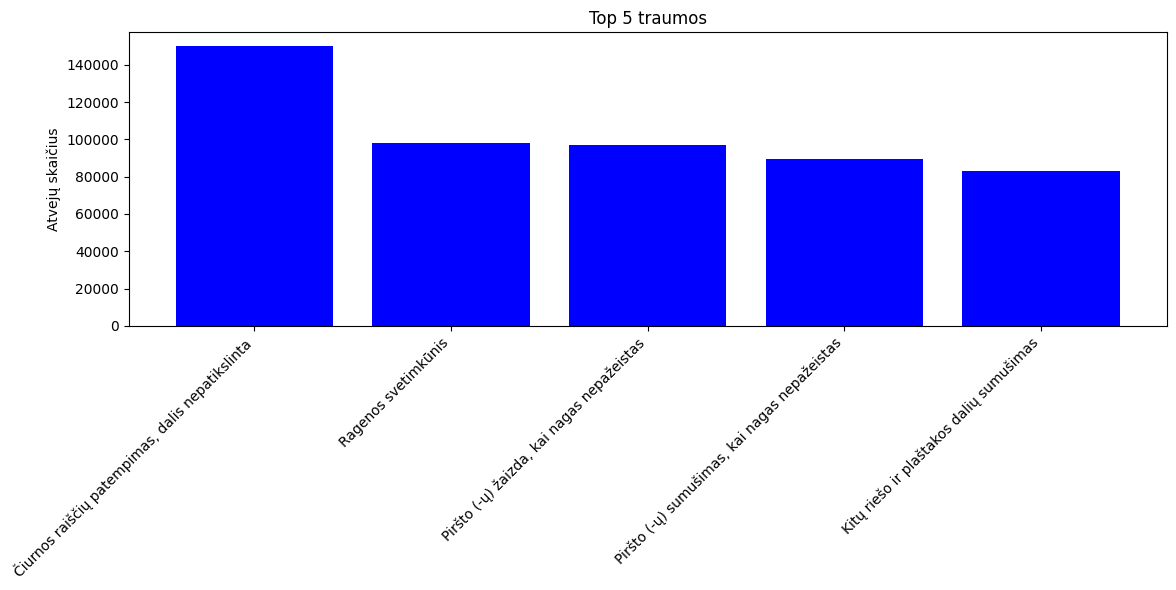

In [5]:
# Patiriamu traumu pasiskirstymas overall
traumu_pasiskirstymas_overall = final_lentele[['ligos_pavadinimas']]
traumu_pasiskirstymas_overall = final_lentele.groupby('ligos_pavadinimas').size().reset_index(name='count')
traumu_pasiskirstymas_overall = traumu_pasiskirstymas_overall.sort_values(by='count', ascending=False).head(5)
traumu_pasiskirstymas_overall

plt.figure(figsize=(12, 6))
plt.bar(traumu_pasiskirstymas_overall['ligos_pavadinimas'], traumu_pasiskirstymas_overall['count'], color='blue')
plt.ylabel('Atvejų skaičius')
plt.title('Top 5 traumos')
plt.xticks(rotation=45, ha='right')   #ha='right'  yra lygiavimas desineje 
plt.tight_layout()
plt.show()

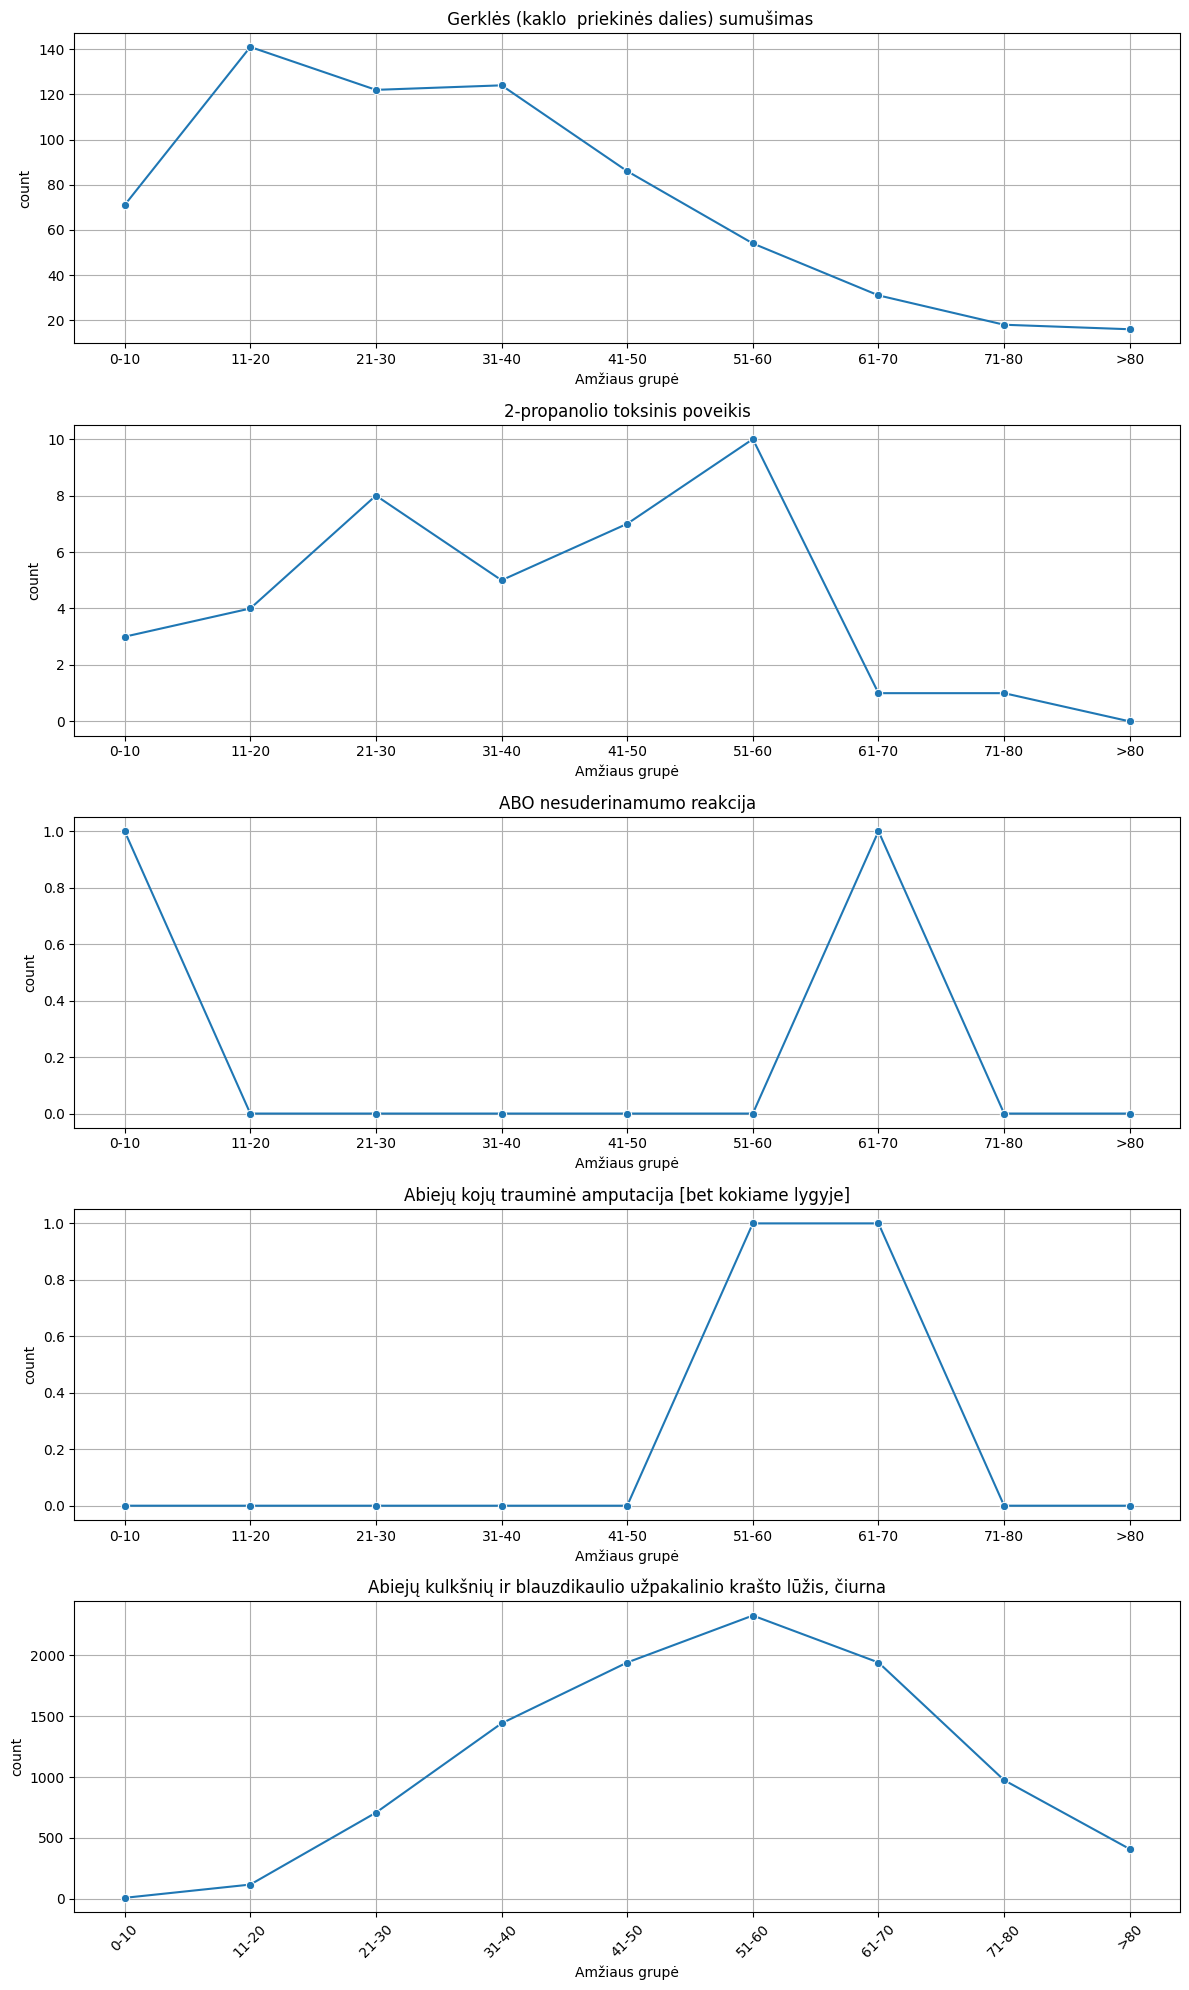

In [6]:
# TOP5 traumu pasiskirstymas pagal amziaus grupes.

traumu_pasiskirstymas_amziu_grupes = final_lentele[['ligos_pavadinimas', 'amziaus_grupe']]
traumu_pasiskirstymas_amziu_grupes = final_lentele.groupby(['ligos_pavadinimas','amziaus_grupe']).size().reset_index(name='count')

fig, axes = plt.subplots(5, 1, figsize=(12, 20))

if len(traumu_pasiskirstymas_amziu_grupes['ligos_pavadinimas'].unique()) == 1:
    axes = [axes]

for ax, (liga, group) in zip(axes, traumu_pasiskirstymas_amziu_grupes.groupby('ligos_pavadinimas')):
    sns.lineplot(data=group, x='amziaus_grupe', y='count', ax=ax, marker='o')
    ax.set_title(liga)
    ax.set_xlabel('Amžiaus grupė')
    ax.set_ylabel('count')
    ax.grid(True)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Patiriamos traumos pagal apsinuodijimu daznius.

apsinuodijimu_daznis = final_lentele
apsinuodijimu_daznis
apsinuodijimu_daznis = apsinuodijimu_daznis[apsinuodijimu_daznis['ligos_pavadinimas'].str.contains('Apsinuod')]
apsinuodijimu_daznis = apsinuodijimu_daznis[['lytis', 'ligos_pavadinimas', 'amziaus_grupe', 'sezonas']]
apsinuodijimu_daznis



,lytis,ligos_pavadinimas,amziaus_grupe,sezonas
116,Vyras,Apsinuodijimas butirofenono ir tioksanteno gru...,0-10,vasara
143,Moteris,Apsinuodijimas benzodiazepinais,41-50,ruduo
157,Vyras,Apsinuodijimas benzodiazepinais,41-50,pavasaris
273,Moteris,Apsinuodijimas kitais ir nepatikslintais vaist...,31-40,žiema
456,Moteris,Apsinuodijimas barbitūratais,51-60,ruduo
...,...,...,...,...
3731322,Vyras,Apsinuodijimas benzodiazepinais,61-70,pavasaris
3731337,Moteris,Apsinuodijimas butirofenono ir tioksanteno gru...,21-30,vasara
3731371,Moteris,Apsinuodijimas antikoaguliantais,>80,vasara
3731383,Moteris,Apsinuodijimas benzodiazepinais,41-50,pavasaris


In [8]:
apsinuodijimai_grupemis = {
    "Neuroleptikai ir antipsichotikai": [
        "Apsinuodijimas butirofenono ir tioksanteno grupės neuroleptikais",
        "Apsinuodijimas kitais ir nepatikslintais antipsichotikais ir neuroleptikais",
        "Apsinuodijimas fenotiazino grupės antipsichotiniais vaistais ir neuroleptikais"
    ],
    "Narkotikai ir psichotropiniai vaistai": [
        "Apsinuodijimas opijumi",
        "Apsinuodijimas heroinu",
        "Apsinuodijimas kanapėmis (dariniais)",
        "Apsinuodijimas kitais sintetiniais narkotikais",
        "Apsinuodijimas kokainu",
        "Apsinuodijimas metilamfetaminu",
        "Apsinuodijimas LSD"
    ],
    "Raminamieji ir migdomieji vaistai": [
        "Apsinuodijimas benzodiazepinais",
        "Apsinuodijimas barbitūratais",
        "Apsinuodijimas nepatikslintais antiepilepsiniais ir raminamaisiais migdomaisiais vaistais"
    ],
    "Analgetikai ir antipiretikai": [
        "Apsinuodijimas 4-aminofenolio dariniais",
        "Apsinuodijimas kitais neopioidiniais analgetikais ir antipiretikais, neklasifikuojamais kitur",
        "Apsinuodijimas salicilatais"
    ],
    "Vaistai nuo širdies ir kraujagyslių ligų": [
        "Apsinuodijimas kitais antihipertenziniais vaistais, neklasifikuojamais kitur",
        "Apsinuodijimas beta adrenoreceptorių antagonistais",
        "Apsinuodijimas angiotenziną konvertuojančio fermento inhibitoriais",
        "Apsinuodijimas alfa adrenoreceptorių antagonistais"
    ],
    "Antikoaguliantai ir kraujo veikiantys vaistai": [
        "Apsinuodijimas antikoaguliantais",
        "Apsinuodijimas antikoaguliantų antagonistais, vitaminu K ir kitais koaguliantais"
    ],
    "Hormonai ir jų antagonistai": [
        "Apsinuodijimas skydliaukės hormonais ir pakaitalais",
        "Apsinuodijimas vaistais nuo Parkinsono ligos ir kitais centriniais raumenų relaksantais",
        "Apsinuodijimas androgenais ir anabolikams giminingais preparatais"
    ],
    "Kiti vaistai ir preparatai": [
        "Apsinuodijimas kitais ir nepatikslintais vaistais, medikamentais ir biologinėmis medžiagomis",
        "Apsinuodijimas vitaminai, neklasifikuojamais kitur",
        "Apsinuodijimas kitais nesteroidiniais vaistais nuo uždegimo",
        "Apsinuodijimas kitais ir nepatikslintais preparatais, veikiančiais širdies ir kraujagyslių sistemą"
    ]
}

ligos_grupes = {ligos_pavadinimas: grupes_pavadinimas for grupes_pavadinimas, ligos_sarasas in apsinuodijimai_grupemis.items() for ligos_pavadinimas in ligos_sarasas}



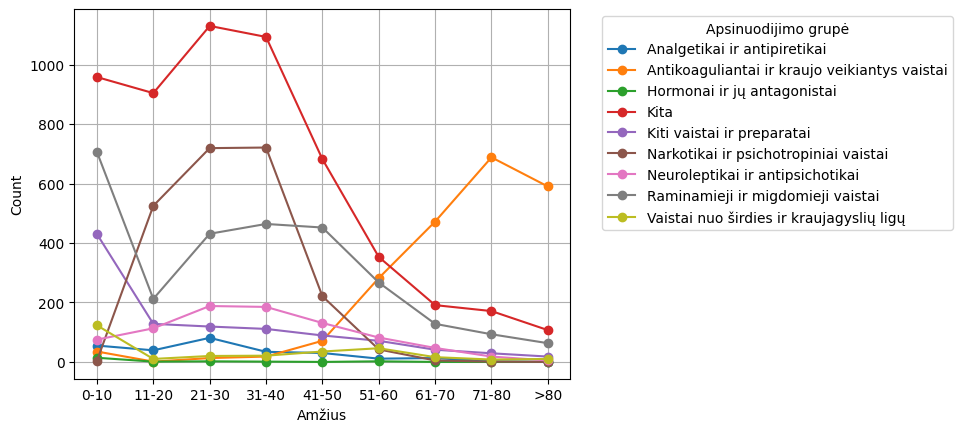

In [9]:
def ligos_grupes_pridejimas(ligos_pavadinimas):
    return ligos_grupes.get(ligos_pavadinimas, "Kita")

apsinuodijimu_daznis['apsinuodijimo_grupe'] = apsinuodijimu_daznis['ligos_pavadinimas'].apply(ligos_grupes_pridejimas)
apsinuodijimu_daznis_vyrai = apsinuodijimu_daznis[['lytis', 'amziaus_grupe', 'apsinuodijimo_grupe']]
apsinuodijimu_daznis_vyrai = apsinuodijimu_daznis[apsinuodijimu_daznis['lytis'] == 'Vyras'][['lytis', 'amziaus_grupe', 'apsinuodijimo_grupe']]
apsinuodijimu_daznis_vyrai


apsinuodijimu_daznis_suvestine = apsinuodijimu_daznis_vyrai.groupby(['amziaus_grupe', 'apsinuodijimo_grupe']).size().unstack()
apsinuodijimu_daznis_suvestine.plot(kind='line', marker='o')


plt.xlabel('Amžius')
plt.ylabel('Count')
plt.grid(True)
plt.legend(title='Apsinuodijimo grupė', bbox_to_anchor=(1.05, 1), loc='upper left')  #Parametras bbox_to_anchor=(1.05, 1) nurodo, kad legenda bus išdėstyta šiek tiek už diagramos dešinės viršutinės dalies, 5% toliau nuo jos krašto.
plt.show()



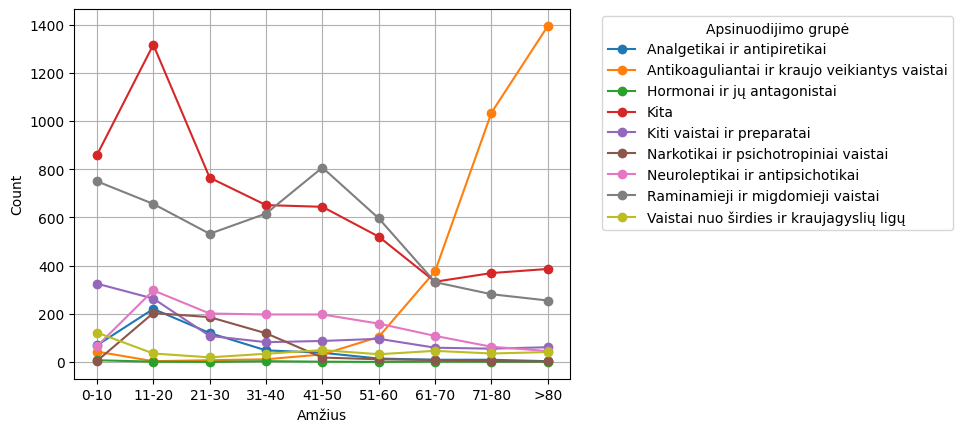

In [10]:
apsinuodijimu_daznis_moterys = apsinuodijimu_daznis[['lytis', 'amziaus_grupe', 'apsinuodijimo_grupe']]
apsinuodijimu_daznis_moterys = apsinuodijimu_daznis[apsinuodijimu_daznis['lytis'] == 'Moteris'][['lytis', 'amziaus_grupe', 'apsinuodijimo_grupe']]
apsinuodijimu_daznis_moterys

apsinuodijimu_daznis_suvestine = apsinuodijimu_daznis_moterys.groupby(['amziaus_grupe', 'apsinuodijimo_grupe']).size().unstack()
apsinuodijimu_daznis_suvestine.plot(kind='line', marker='o')


plt.xlabel('Amžius')
plt.ylabel('Count')
plt.grid(True)
plt.legend(title='Apsinuodijimo grupė', bbox_to_anchor=(1.05, 1), loc='upper left')  #Parametras bbox_to_anchor=(1.05, 1) nurodo, kad legenda bus išdėstyta šiek tiek už diagramos dešinės viršutinės dalies, 5% toliau nuo jos krašto.
plt.show()

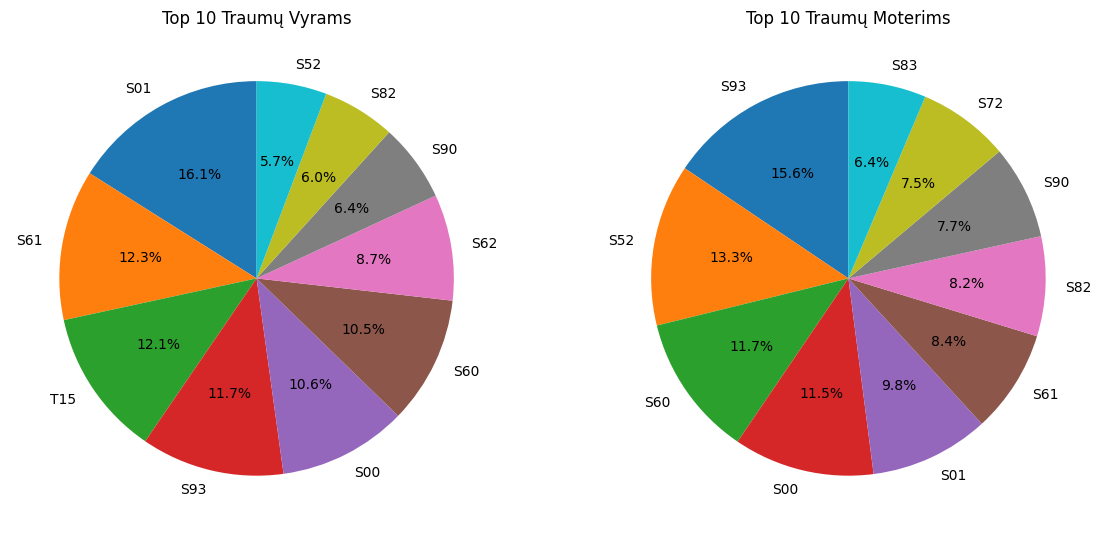

In [11]:
# Patiriamos traumos pagal lytis.

traumos_pagal_lytis = final_lentele[['lytis', 'ligos_pavadinimas', 'tlk_trauma']]
traumos_pagal_lytis['tlk_trauma'] = traumos_pagal_lytis['tlk_trauma'].str.split('.').str[0]

vyrai = traumos_pagal_lytis[traumos_pagal_lytis['lytis'] == 'Vyras']
vyrai = vyrai.groupby('tlk_trauma').size().reset_index(name='count')
top10_vyrai = vyrai.sort_values(by='count', ascending=False).head(10)

moterys = traumos_pagal_lytis[traumos_pagal_lytis['lytis'] == 'Moteris']
moterys = moterys.groupby('tlk_trauma').size().reset_index(name='count')
top10_moterys = moterys.sort_values(by='count', ascending=False).head(10)

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].pie(top10_vyrai['count'], labels=top10_vyrai['tlk_trauma'], autopct='%1.1f%%', startangle=90)
axes[0].set_title('Top 10 Traumų Vyrams')
axes[1].pie(top10_moterys['count'], labels=top10_moterys['tlk_trauma'], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Top 10 Traumų Moterims')
plt.show()

In [12]:
# Ar traumų pobūdis/dažnis, apsinuodijimų kiekis, pobūdis, sunkumas priklauso nuo užfiksuotų meteorologinių sąlygų, mėnulio fazės, švenčių/laisvadienių?

final_lentele

moon_phases = pd.read_csv('C:/Users/Pauliussl/Paskaita85/moon_phases.csv')
moon_phases = moon_phases[['datetime', 'phase']]

# Konvertuoti 'datetime' stulpelį į datetime objektą
moon_phases['datetime'] = pd.to_datetime(moon_phases['datetime'])

# Dabar 'moon_phases' DataFrame yra pasiruoštas jungimui su kita lentele
moon_phases

,datetime,phase
0,2020-01-03 06:45:00,First Quarter
1,2020-01-10 21:21:00,Full Moon
2,2020-01-17 14:58:00,Last Quarter
3,2020-01-24 23:42:00,New Moon
4,2020-02-02 03:42:00,First Quarter
...,...,...
292,2025-11-28 08:59:00,First Quarter
293,2025-12-05 01:14:00,Full Moon
294,2025-12-11 22:52:00,Last Quarter
295,2025-12-20 03:43:00,New Moon


In [13]:
import pandas as pd

moon_phases = pd.read_csv('C:/Users/Pauliussl/Paskaita85/moon_phases.csv')
moon_phases = moon_phases[['datetime', 'phase']]
moon_phases['datetime'] = pd.to_datetime(moon_phases['datetime']).dt.date
moon_phases

ligonine = pd.read_csv('C:/Users/Pauliussl/Paskaita85/Ligonine.csv')
ligonine['gyd_lap_pradzia'] = pd.to_datetime(ligonine['gyd_lap_pradzia']).dt.date
ligonine = ligonine[ligonine['gyd_lap_pradzia'] >= pd.to_datetime('2020-01-03').date()]
ligonine = ligonine['gyd_lap_pradzia']
ligonine = ligonine.to_frame()
ligonine




,gyd_lap_pradzia
2,2023-05-03
4,2023-12-20
7,2021-03-14
11,2023-08-07
16,2023-07-20
...,...
3730799,2021-12-09
3730800,2023-02-21
3730803,2020-10-05
3730804,2021-06-16


In [14]:
final_lentele2 = pd.merge(ligonine, moon_phases, left_on='gyd_lap_pradzia', right_on='datetime', how='left')
final_lentele2 = final_lentele2.sort_values(by='gyd_lap_pradzia')
final_lentele2['phase'] = final_lentele2['phase'].fillna(method='ffill')
final_lentele2 = final_lentele2[['gyd_lap_pradzia', 'phase']]
final_lentele2

,gyd_lap_pradzia,phase
706364,2020-01-03,First Quarter
993916,2020-01-03,First Quarter
385806,2020-01-03,First Quarter
1082372,2020-01-03,First Quarter
489950,2020-01-03,First Quarter
...,...,...
312790,2023-12-31,Full Moon
1114598,2023-12-31,Full Moon
961577,2023-12-31,Full Moon
597466,2023-12-31,Full Moon


In [15]:
menulio_faziu_periodas = final_lentele2.groupby('phase').size().reset_index(name='count')
menulio_faziu_periodas

,phase,count
0,First Quarter,320359
1,Full Moon,323121
2,Last Quarter,324845
3,New Moon,332205


In [16]:
moon_phases = pd.read_csv('C:/Users/Pauliussl/Paskaita85/moon_phases.csv')
moon_phases = moon_phases[['datetime', 'phase']]
moon_phases['datetime'] = pd.to_datetime(moon_phases['datetime']).dt.date
moon_phases

ligonine = pd.read_csv('C:/Users/Pauliussl/Paskaita85/Ligonine.csv')
ligonine['gyd_lap_pradzia'] = pd.to_datetime(ligonine['gyd_lap_pradzia']).dt.date
ligonine = ligonine[ligonine['gyd_lap_pradzia'] >= pd.to_datetime('2020-01-03').date()]
ligonine = ligonine['gyd_lap_pradzia']
ligonine = ligonine.to_frame()
ligonine

final_lentele2 = pd.merge(ligonine, moon_phases, left_on='gyd_lap_pradzia', right_on='datetime', how='left')
final_lentele2 = final_lentele2.sort_values(by='gyd_lap_pradzia')
final_lentele2 = final_lentele2[['gyd_lap_pradzia', 'phase']]
final_lentele2 = final_lentele2.dropna()
final_lentele2 = final_lentele2.dropna()
final_lentele2

,gyd_lap_pradzia,phase
706364,2020-01-03,First Quarter
993916,2020-01-03,First Quarter
385806,2020-01-03,First Quarter
1082372,2020-01-03,First Quarter
489950,2020-01-03,First Quarter
...,...,...
257138,2023-12-27,Full Moon
799266,2023-12-27,Full Moon
878968,2023-12-27,Full Moon
697248,2023-12-27,Full Moon


In [17]:
final_lentele2 = final_lentele2.dropna()
final_lentele2

phase_counts2 = final_lentele2.groupby('phase').size().reset_index(name='count')
phase_counts2

,phase,count
0,First Quarter,44852
1,Full Moon,43484
2,Last Quarter,42493
3,New Moon,44948


In [18]:
# Uzduotis nr. 2 - Policijos ir PAGD iskvietimai
# Ar iškvietimų dažnis/kiekis priklauso nuo paros, metų, darbo dienų/švenčių/išeiginių, mėnulio fazės, švenčių/laisvadienių?

moon_phases = pd.read_csv('C:/Users/Pauliussl/Paskaita85/moon_phases.csv')

In [19]:
import json

with open(r'C:\Users\Pauliussl\Paskaita85\Iskvietimai\prir_2023_03_31.json', 'r', encoding='utf-8') as file:
    Pirmas_ketv = json.load(file)

with open(r'C:\Users\Pauliussl\Paskaita85\Iskvietimai\prir_2023_06_30.json', 'r', encoding='utf-8') as file:
    Antras_ketv = json.load(file)

with open(r'C:\Users\Pauliussl\Paskaita85\Iskvietimai\prir_2023_09_30.json', 'r', encoding='utf-8') as file:
    Trecias_ketv = json.load(file)

with open(r'C:\Users\Pauliussl\Paskaita85\Iskvietimai\prir_2023_12_31.json', 'r', encoding='utf-8') as file:
    Ketvirtas_ketv = json.load(file)

df1 = pd.DataFrame(Pirmas_ketv)
df2 = pd.DataFrame(Antras_ketv)
df3 = pd.DataFrame(Trecias_ketv)
df4 = pd.DataFrame(Ketvirtas_ketv)

bendra_lentele = pd.concat([df1, df2, df3, df4], ignore_index=True)



In [20]:
bendra_lentele = bendra_lentele[['ivykioData', 'kategorija', 'tipas2', 'policijosIstaiga', 'vieta', 'vieta2', 'savivaldybe']]
bendra_lentele['ivykioData'] = pd.to_datetime(bendra_lentele['ivykioData'])
bendra_lentele['Data'] = bendra_lentele['ivykioData'].dt.date
bendra_lentele['Valanda'] = bendra_lentele['ivykioData'].dt.hour
bendra_lentele['SavaitesDiena'] = bendra_lentele['ivykioData'].dt.day_name()

def sav_dienos(x):
    if x in ['Saturday', 'Sunday']:
        return 'Savaitgalis'
    else:
        return 'Darbo diena'
    
bendra_lentele['Diena_Tipas'] = bendra_lentele['SavaitesDiena'].apply(sav_dienos)

bendra_lentele_tik_iskvietimai = bendra_lentele[['tipas2','Data', 'Valanda', 'SavaitesDiena', 'Diena_Tipas']]

In [21]:
bendra_lentele_tik_iskvietimai

,tipas2,Data,Valanda,SavaitesDiena,Diena_Tipas
0,Įvairūs viešosios tvarkos pažeidimai,2023-01-01,0,Sunday,Savaitgalis
1,KET pažeidimas,2023-01-01,0,Sunday,Savaitgalis
2,Nusikaltimai asmeniui dabar,2023-01-01,0,Sunday,Savaitgalis
3,Įvairūs viešosios tvarkos pažeidimai,2023-01-01,0,Sunday,Savaitgalis
4,Pagalba specialiosioms tarnyboms,2023-01-01,0,Sunday,Savaitgalis
...,...,...,...,...,...
782056,Nusikaltimai asmeniui dabar,2023-12-31,23,Sunday,Savaitgalis
782057,Smurtas artimoje aplinkoje,2023-12-31,23,Sunday,Savaitgalis
782058,Įvairūs viešosios tvarkos pažeidimai,2023-12-31,23,Sunday,Savaitgalis
782059,Asmens paieška,2023-12-31,23,Sunday,Savaitgalis


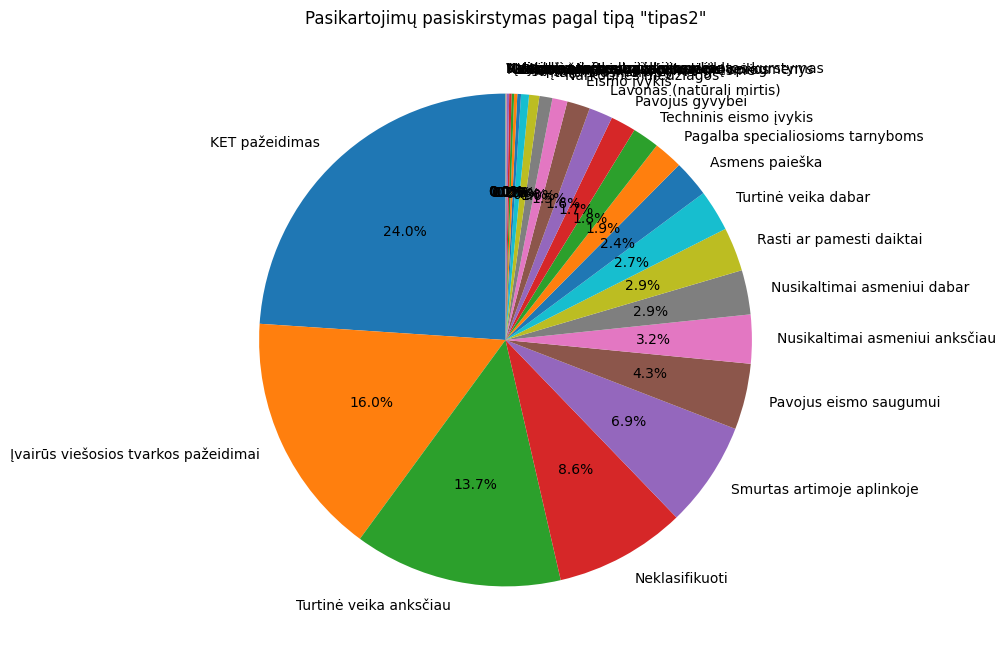

In [22]:
nusizengimu_count = bendra_lentele_tik_iskvietimai['tipas2'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(nusizengimu_count, labels=nusizengimu_count.index, autopct='%1.1f%%', startangle=90)
plt.title('Pasikartojimų pasiskirstymas pagal tipą "tipas2"')
plt.show()

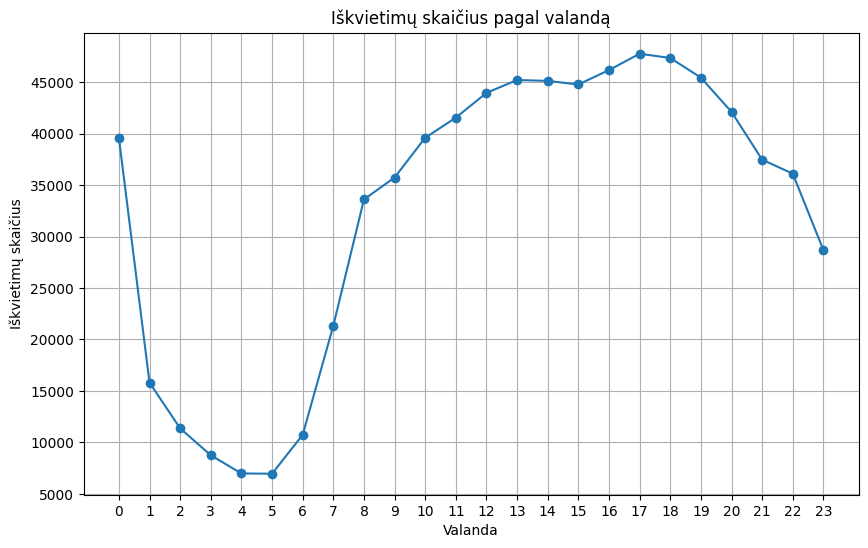

In [23]:
valandos_count = bendra_lentele_tik_iskvietimai.groupby('Valanda').size()
plt.figure(figsize=(10, 6))
plt.plot(valandos_count.index, valandos_count.values, marker='o')
plt.title('Iškvietimų skaičius pagal valandą')
plt.xlabel('Valanda')
plt.ylabel('Iškvietimų skaičius')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

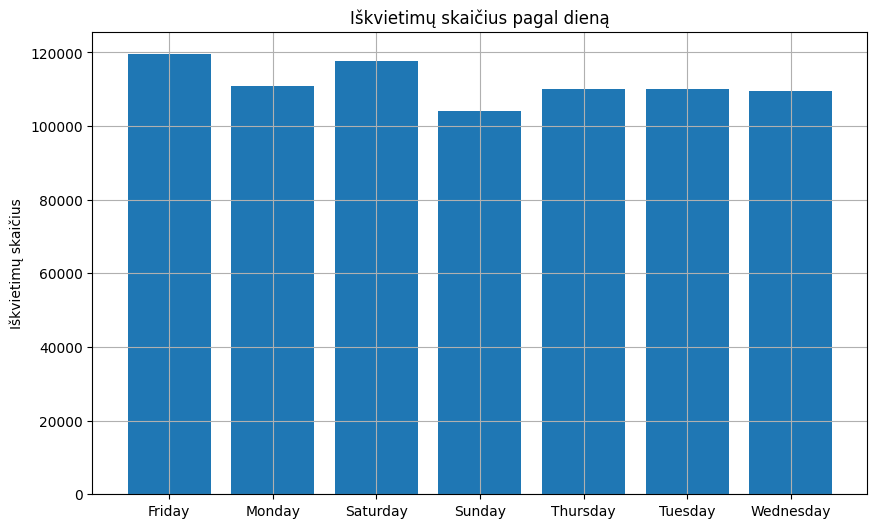

In [24]:
savaites_dienos_count = bendra_lentele_tik_iskvietimai.groupby('SavaitesDiena').size()
plt.figure(figsize=(10, 6))
plt.bar(savaites_dienos_count.index, savaites_dienos_count.values)
plt.title('Iškvietimų skaičius pagal dieną')
plt.ylabel('Iškvietimų skaičius')
plt.grid(True)
plt.show()

In [25]:
sventes_datas = ["2023-01-01", "2023-02-16", "2023-02-21", "2023-03-11", "2023-04-09", "2023-04-10", "2023-05-01", "2023-05-07", "2023-06-04", "2023-06-24", "2023-07-06", "2023-08-15", "2023-11-01", "2023-11-02", "2023-12-24", "2023-12-25", "2023-12-26"]

# Sventiniu dienu paskaiciavimas